# Методы Explainability, специфичные для трансформеров

В трансформерах есть механизм **self-attention**, который кажется естественным способом определить, какие токены текста/кусочки изображения имеют большую важность для предсказания.

<center><img src ="https://edunet.kea.su/repo/EduNet-additions/AR/self_attention.png"  width="900"></center>

Это бы отлично работало, будь у нас только один блок **self-attention**, но архитектура трансформера состоит из **нескольких блоков кодера/декодера**, составленных друг за другом. От слоя к слою за счет того же **self-attention** **информация в эмбеддингах перемешивается** сильнее и сильнее. Так, например, для классификации текста мы можем использовать эмбеддинг на выходе **BERT**, соответствующий `[CLS]` токену , в котором на входе **BERT** не было никакой информации о последующем тексте.

<center><img src ="https://edunet.kea.su/repo/EduNet-additions/AR/transformer_text_translation_example.png" width="800">

<em>Source: [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/)</em></center>

Кроме того, в стандартном блоке трансформера есть **residual соединения**. Из-за этого информация о токенах/патчах проходит не только через **attention**, но и через **residual соединения**.

<center><img src ="https://edunet.kea.su/repo/EduNet-additions/AR/transformer_architecture.png" width="450">

<em>Архитектура трансформера</em>

<em>Source: <a href="https://arxiv.org/pdf/1706.03762.pdf"> Attention Is All You Need</a></em></center>

По этим причинам объяснение работы трансформера через attention — непростая задача.

**Предупреждение:** методы объяснения **attention** только частично объясняют работу трансформера, они  разнообразны и могут давать противоречивые результаты.

Давайте для начала немного поизучаем, как выглядят значения self-attention в трансформерах. Подгружаем библиотеку.

In [ ]:
from IPython.display import clear_output

try:
    import transformers
except ModuleNotFoundError:
    !pip install sentencepiece
    !pip install transformers
    clear_output()

Возьмем базовый русскоязычный разговорный [BERT от Deep Pavlov](https://huggingface.co/DeepPavlov/rubert-base-cased-conversational), [обученный](https://huggingface.co/blanchefort/rubert-base-cased-sentiment) для определения настроения коротких русских текстов. Загружаем токенизатор и модель. Ставим флаг `output_attentions=True`, чтобы модель возвращала значения attention.

In [ ]:
import transformers
from transformers import BertTokenizerFast, AutoModelForSequenceClassification

tokenizer = BertTokenizerFast.from_pretrained(
    "blanchefort/rubert-base-cased-sentiment",
)
model = AutoModelForSequenceClassification.from_pretrained(
    "blanchefort/rubert-base-cased-sentiment",
    output_attentions=True,  # for save attention
)

Готовим предложения.

In [ ]:
sentences = [
    "Мама мыла раму",
    "Фильм сделан откровенно плохо",
    "Максимально скучный сериал, где сюжет высосан из пальца",
    "Я был в восторге",
    "В общем, кино хорошее и есть много что пообсуждать"
]

tokens = [
    ['[cls]'] + tokenizer.tokenize(sentence)+['[sep]'] for sentence in sentences
]

Посмотрим, как разбивается на токены предложение. На выходе токенизатора номера токенов.

In [ ]:
item = 0
print(f"Tokens: {tokens[item]}")
token_ids = [tokenizer.encode(sentence) for sentence in sentences]
print(f"Token ids: {token_ids[item]}")

Tokens: ['[cls]', 'Мама', 'мыла', 'раму', '[sep]']
Token ids: [101, 10871, 49053, 53954, 102]


Посмотрим на предсказания модели, чтобы проверить, насколько она адекватна.

In [ ]:
import torch


ans = {
    0: "NEUTRAL",
    1: "POSITIVE",
    2: "NEGATIVE"
}

for item in range(5):
    input_ids = torch.tensor([token_ids[item]])
    model_output = model(input_ids)
    predicted = torch.argmax(model_output.logits, dim=1).numpy()
    print(f"Text: {sentences[item]}")
    print(f"Predict lable = {predicted}, {ans[predicted.item()]}")

Text: Мама мыла раму
Predict lable = [0], NEUTRAL
Text: Фильм сделан откровенно плохо
Predict lable = [2], NEGATIVE
Text: Максимально скучный сериал, где сюжет высосан из пальца
Predict lable = [2], NEGATIVE
Text: Я был в восторге
Predict lable = [1], POSITIVE
Text: В общем, кино хорошее и есть много что пообсуждать
Predict lable = [0], NEUTRAL


В данной моделе 12 слоев (блоков трансформеров), поэтому модель возвращает кортеж из 12 тензоров. Каждый слой имеет 12 голов self-attention.

In [ ]:
item = 1
input_ids = torch.tensor([token_ids[item]])
model_output = model(input_ids)

attentions = model_output.attentions
print(f"Text: {sentences[item]}")
print(f"Tokens: {tokens[item]}")
print(f"Number of layers: {len(attentions)}")
print(f"Attention size: {attentions[0].shape} "
       "[batch x attention_heads x seq_size x seq_size]")

Text: Фильм сделан откровенно плохо
Tokens: ['[cls]', 'Фильм', 'сделан', 'откровенно', 'плохо', '[sep]']
Number of layers: 12
Attention size: torch.Size([1, 12, 6, 6]) [batch x attention_heads x seq_size x seq_size]


Преобразуем в однородный массив для удобства манипуляций.

Код этой части лекции основан на [репозитории](https://github.com/samiraabnar/attention_flow).
[Cтатья](https://arxiv.org/pdf/2005.00928.pdf).


In [ ]:
import numpy as np

def to_array(attentions):
    attentions_arr = [attention.detach().numpy() for attention in attentions]
    return  np.asarray(attentions_arr)[:, 0]

attentions_arr = to_array(attentions)
print(f"Shape: {attentions_arr.shape} "
      "[layers x attention_heads x seq_size x seq_size]")
print(f"Type: {type(attentions_arr)}, Dtype: {attentions_arr.dtype}")

Shape: (12, 12, 6, 6) [layers x attention_heads x seq_size x seq_size]
Type: <class 'numpy.ndarray'>, Dtype: float32


Посмотрим на **нулевую голову нулевого слоя**

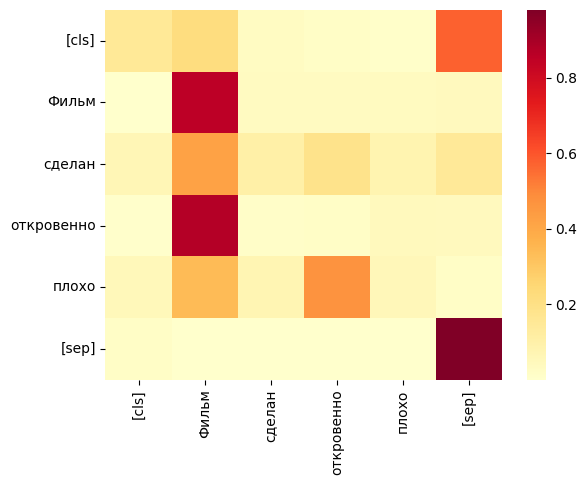

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

x_ticks = tokens[item]
y_ticks = tokens[item]

sns.heatmap(
    attentions_arr[0][0],
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    cmap="YlOrRd",
)

plt.show()

Тут по **оси x** — токены, **на** которые смотрит внимание, по **оси y** — токены, **куда** записывается результат прохождения слоя.

Так для слова “плохо” первая голова внимания первого слоя больше всего смотрит на слова “фильм” и “ откровенно”.

Для визуализации внимания можно использовать библиотеку [bertviz](https://pypi.org/project/bertviz/) ([статья](https://arxiv.org/pdf/1904.02679.pdf),
[код](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing))

In [ ]:
try:
    import bertviz
except ModuleNotFoundError:
    !pip install bertviz
    clear_output()

Тут Layer — это выбор слоя, цвета — головы self-attention, слева — куда записывается, справа — на какие токены смотрит. Яркость соединяющих линий — величина attention (чем ярче, тем больше). Картину, аналогичную картине выше, можно получить, *дважды щелкнув на первый синий квадрат*.

In [ ]:
import bertviz
from bertviz import head_view

head_view(model_output.attentions, tokens[item])

<IPython.core.display.Javascript object>

Усредним значения по головам:

In [ ]:
def head_sum(attention_arr):
    return attentions_arr.sum(axis=1)/attentions_arr.shape[1]

attention_head_sum = head_sum(attentions_arr)
print(f"{attention_head_sum.shape} [layers x seq_size x seq_size]")

(12, 6, 6) [layers x seq_size x seq_size]


Посмотрим на усредненное по головам внимание **на первом слое**:

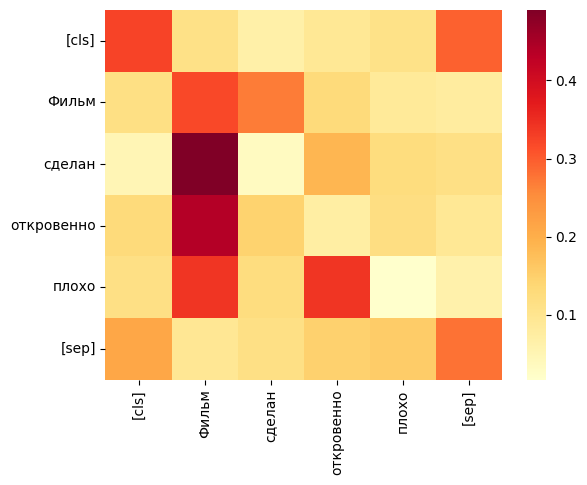

In [ ]:
x_ticks = tokens[item]
y_ticks = tokens[item]

sns.heatmap(
    attention_head_sum[0],
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    cmap="YlOrRd",
)

plt.show()

И на **последнем слое**:

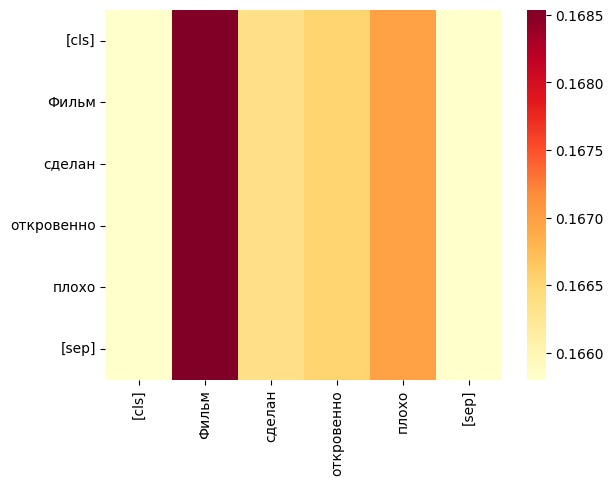

In [ ]:
x_ticks = tokens[item]
y_ticks = tokens[item]

sns.heatmap(
    attention_head_sum[11],
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    cmap="YlOrRd",
)

plt.show()

По значениям справа от графика видно, что внимание на последнем слое изменяется в **узком диапазоне значений**.

Посмотрим на **значения внимания для записываемого в эмбеддинг [CLS] токена** (эмбеддинг с него используется для классификации).

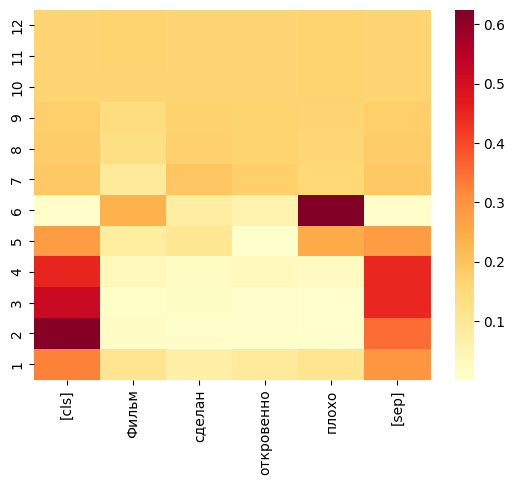

In [ ]:
x_ticks = tokens[item]
y_ticks = [i for i in range(12, 0, -1)]

sns.heatmap(
    np.flip(attention_head_sum[:, 0, :], axis=0),
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    cmap="YlOrRd"
)

plt.show()

Видно, что после 6-го слоя значения внимания выравниваются. Это связано с тем, что механизм **self-attention** смешивает информацию о токенах.

<font size="5">Residual connection</font>

Давайте сначала определимся, что делать с **residual соединениями**.

<center><img src ="https://edunet.kea.su/repo/EduNet-additions/AR/transformer_architecture.png" width="450"></center>

**Residual соединение** можно записать как

$$ \large V_{l+1} = V_l + W_{att}V_l,$$

где $W_{att}$ — матрица внимания, а $V_l$ — эмбеддинги.

После нормализации это можно переписать как

$$\large A=0.5W{att}+0.5I,$$

где $I$ — единичная матрица.

[Подробнее](https://arxiv.org/pdf/2005.00928.pdf)

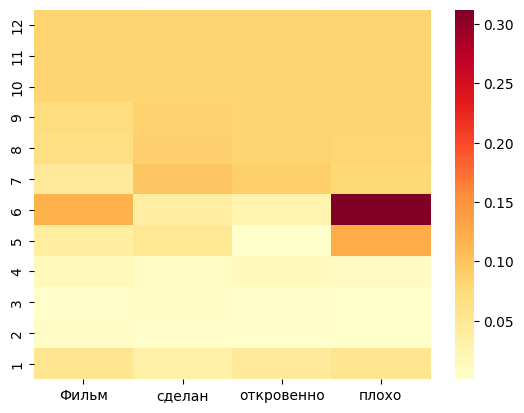

In [ ]:
def residual(attention_head_sum):
     attention_head_sum += np.eye(attention_head_sum.shape[1])[None,...]
     return attention_head_sum / attention_head_sum.sum(axis=-1)[...,None]

attention_res = residual(attention_head_sum)

x_ticks = tokens[item][1:-1]
y_ticks = [i for i in range(12, 0, -1)]

sns.heatmap(
    np.flip(attention_res[:, 0, 1:-1], axis=0),
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    cmap="YlOrRd"
)

plt.show()

## Attention rollout
“Разворачивание внимания” (**Attention rollout**) — предложенный в [статье](https://arxiv.org/pdf/2005.00928.pdf) способ отслеживания информации, распространяемой от входного к выходному блоку, в котором значение внимания рассматривается как доля пропускаемой информации.  Доли информации перемножаются и суммируются. Итоговая формула — рекурсивное матричное перемножение.

\begin{align}
\widetilde{A}(l_i) = \left\{
\begin{array}{cl}
A(l_i)\widetilde{A}(l_{i-1}) & i>0 \\
A(l_i) & i = 0.
\end{array}
\right.
\end{align}



In [ ]:
def rollout(attention_res):
    rollout_attantion = np.zeros(attention_res.shape)
    rollout_attantion[0] = attention_res[0]
    n_layers = attention_res.shape[0]
    for i in range(1, n_layers):
        rollout_attantion[i] = attention_res[i].dot(rollout_attantion[i-1])
    return rollout_attantion

In [ ]:
rollout_attention = rollout(attention_res)

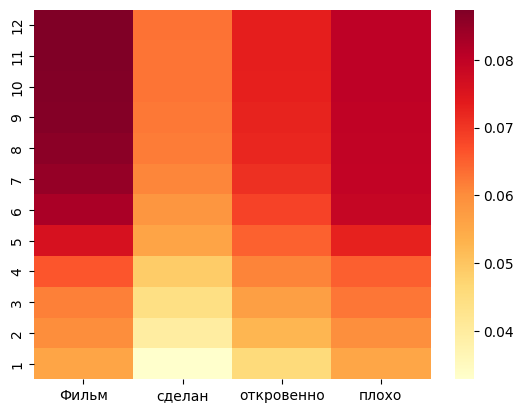

In [ ]:
x_ticks = tokens[item][1:-1]
y_ticks = [i for i in range(12, 0, -1)]

sns.heatmap(
    np.flip(rollout_attention[:, 0, 1:-1], axis=0),
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    cmap="YlOrRd"
)

plt.show()

Реализацию для ViT и картинок можно найти [тут](https://huggingface.co/spaces/probing-vits/attention-rollout/tree/main) (API упало, но код рабочий, проверено).

Реализация на PyTorch rollout и некоторых других методов для BERT: [API](https://huggingface.co/spaces/amsterdamNLP/attention-rollout), [код](https://huggingface.co/spaces/amsterdamNLP/attention-rollout/tree/main).

## Attention Flow

Другим вариантом рассмотрения распространения внимания является **attention flow**. В нем трансформер представляют в виде направленного графа, **узлы** которого представляют собой **эмбеддинги** между слоями, а **ребра** — связи в виде **attention** с ограниченной емкостью (передающей способностью).

<center><img src ="https://edunet.kea.su/repo/EduNet-additions/AR/attention_flow.png" width="700">

<em>Source: <a href="https://github.com/samiraabnar/attention_flow/blob/master/bert_example.ipynb">Bert Example
</a></em></center>

В такой постановке задача нахождения важности токенов/частей изображения в результирующем эмбеддинге сводится к [задаче о максимальном потоке](https://ru.wikipedia.org/wiki/%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BE_%D0%BC%D0%B0%D0%BA%D1%81%D0%B8%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC_%D0%BF%D0%BE%D1%82%D0%BE%D0%BA%D0%B5) (задача нахождения такого потока по транспортной сети, чтобы сумма потоков в пункт назначения была максимальна). Это известная алгоритмическая задача, которую мы не будем разбирать в рамках этого курса.

[Код](https://github.com/samiraabnar/attention_flow), [статья](https://arxiv.org/pdf/2005.00928.pdf).



## Gradient-weighted Attention Rollout

Метод, объединяющий GradCam и Attention Rollout, позволяет оценить положительный и отрицательный вклад токенов/частей изображения в итоговый результат. Предложен в [статье](https://openaccess.thecvf.com/content/CVPR2021/papers/Chefer_Transformer_Interpretability_Beyond_Attention_Visualization_CVPR_2021_paper.pdf), реализацию можно найти тут: [API](https://huggingface.co/spaces/amsterdamNLP/attention-rollout), [код](https://huggingface.co/spaces/amsterdamNLP/attention-rollout/tree/main).

Методы, основанные на механизме внимания, только частично объясняют работу трансформера и на сегодняшний день не являются надежным методом оценки важности признаков.